# Credit Card Approvals

#### Import Packages

In [1]:
#Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly as py
import datetime as dt
import scipy as scp

#linear regression
from pylab import *
import statsmodels.api as sm
import statsmodels.stats.api as sms


#Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#### Create dFs

In [2]:
applications = pd.read_csv('application_record.csv')
records = pd.read_csv('credit_record.csv')

## Data Exploration and Wrangling

In [3]:
applications.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
records.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
applications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [6]:
applications.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [7]:
records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [8]:
# subset data - drop variables that most likely won't affect the DV.
applications2 = applications.drop(['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'], axis=1)

In [9]:
# Rename columns
applications2.rename(columns={'CODE_GENDER': 'gender', 'FLAG_OWN_CAR' : 'ownsCar', 'FLAG_OWN_REALTY' : 'ownsRealty', 'CNT_CHILDREN' : 'numChildren', 'AMT_INCOME_TOTAL' : 'totalIncome', 'NAME_INCOME_TYPE' : 'incomeType', 'NAME_EDUCATION_TYPE' : 'EduLvl', 'NAME_FAMILY_STATUS': 'famStatus', 'NAME_HOUSING_TYPE' : 'housingType', 'DAYS_BIRTH' : 'daysBirth', 'DAYS_EMPLOYED' : 'daysEmpl', 'OCCUPATION_TYPE' : 'occupation', 'CNT_FAM_MEMBERS' : 'famSize'}, inplace = True)

In [10]:
# convert daysBirth to Age in years
applications2['age'] = np.ceil(pd.to_timedelta(applications2['daysBirth'], unit='D').dt.days / -365.25)
applications2.drop('daysBirth', axis = 1, inplace = True)

In [11]:
# convert daysEmpl to yrsEmpl
applications2['yrsEmpl']=-applications2['daysEmpl']/365.2425
applications2.loc[applications2['yrsEmpl']<0,'yrsEmpl']=0
applications2.drop('daysEmpl', axis=1, inplace=True)

In [45]:
applications2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304354 entries, 2 to 438556
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ID           304354 non-null  int64  
 1   gender       304354 non-null  object 
 2   ownsCar      304354 non-null  object 
 3   ownsRealty   304354 non-null  object 
 4   numChildren  304354 non-null  int64  
 5   totalIncome  304354 non-null  float64
 6   incomeType   304354 non-null  object 
 7   EduLvl       304354 non-null  object 
 8   famStatus    304354 non-null  object 
 9   housingType  304354 non-null  object 
 10  occupation   304354 non-null  object 
 11  famSize      304354 non-null  float64
 12  age          304354 non-null  float64
 13  yrsEmpl      304354 non-null  float64
dtypes: float64(4), int64(2), object(8)
memory usage: 34.8+ MB


In [12]:
applications2.head()

,ID,gender,ownsCar,ownsRealty,numChildren,totalIncome,incomeType,EduLvl,famStatus,housingType,occupation,famSize,age,yrsEmpl
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,NaN,2.0,33.0,12.435574
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,NaN,2.0,33.0,12.435574
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,Security staff,2.0,59.0,3.104787
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,1.0,53.0,8.353354
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,1.0,53.0,8.353354


In [44]:
applications2.tail(10)

,ID,gender,ownsCar,ownsRealty,numChildren,totalIncome,incomeType,EduLvl,famStatus,housingType,occupation,famSize,age,yrsEmpl
438535,6837236,F,N,Y,0,135000.0,Working,Secondary / secondary special,Married,House / apartment,Laborers,2.0,38.0,2.992532
438536,6837264,F,N,N,2,90000.0,State servant,Higher education,Single / not married,House / apartment,Core staff,4.0,44.0,3.490831
438537,6837450,M,N,Y,1,135000.0,Working,Secondary / secondary special,Separated,House / apartment,Security staff,2.0,36.0,0.490085
438538,6837452,M,N,N,1,135000.0,Working,Secondary / secondary special,Separated,House / apartment,Security staff,2.0,36.0,0.490085
438539,6837454,M,Y,Y,1,162000.0,State servant,Secondary / secondary special,Married,House / apartment,Core staff,3.0,30.0,7.323901
438541,6837707,M,N,Y,0,202500.0,Working,Higher education,Civil marriage,House / apartment,Laborers,2.0,37.0,6.321827
438548,6839936,M,Y,Y,1,135000.0,Working,Secondary / secondary special,Married,House / apartment,Laborers,3.0,35.0,5.735915
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,1.0,44.0,8.232886
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,Sales staff,1.0,23.0,1.018501
438556,6842885,F,N,Y,0,121500.0,Working,Secondary / secondary special,Married,House / apartment,Sales staff,2.0,52.0,3.288226


In [13]:
# drop missing values
applications2.dropna(inplace = True)

In [14]:
# drop duplicates
applications3=applications2.drop_duplicates(subset=applications2.columns[1:], keep='first')

In [15]:
applications3.head()

,ID,gender,ownsCar,ownsRealty,numChildren,totalIncome,incomeType,EduLvl,famStatus,housingType,occupation,famSize,age,yrsEmpl
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,Security staff,2.0,59.0,3.104787
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,1.0,53.0,8.353354
10,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,Accountants,2.0,47.0,2.105450
13,5008819,M,Y,Y,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,2.0,49.0,3.269061
19,5008825,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,Accountants,2.0,30.0,3.019911


In [16]:
# find income range represented in this data set
minInc = applications3.totalIncome.min()
print("The lowest applicant income is" , minInc)

The lowest applicant income is 27000.0


In [17]:
maxInc = applications3.totalIncome.max()
print("The maximum applicant income is" , maxInc)

The maximum applicant income is 6750000.0


In [18]:
#total income with outliers
applications3.totalIncome.describe()

count    6.258200e+04
mean     1.854914e+05
std      1.075549e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      6.750000e+06
Name: totalIncome, dtype: float64

In [19]:
applications3.isna().sum()

ID             0
gender         0
ownsCar        0
ownsRealty     0
numChildren    0
totalIncome    0
incomeType     0
EduLvl         0
famStatus      0
housingType    0
occupation     0
famSize        0
age            0
yrsEmpl        0
dtype: int64

In [20]:
applications3['occupation'].unique()

array(['Security staff', 'Sales staff', 'Accountants', 'Laborers',
       'Managers', 'Drivers', 'Core staff', 'High skill tech staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Low-skill Laborers', 'Medicine staff', 'Secretaries',
       'Waiters/barmen staff', 'HR staff', 'Realty agents', 'IT staff'],
      dtype=object)

### Data Visualization

Text(0.5, 1.0, 'Applicant Income Dist')

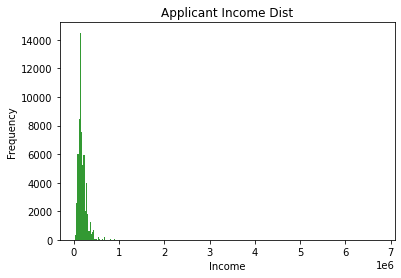

In [21]:
num_bins = 250
n, bins, patches = plt.hist(applications3['totalIncome'], num_bins, facecolor='green', alpha = .8)
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Applicant Income Dist')

<AxesSubplot:>

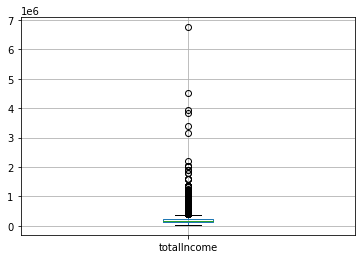

In [22]:
# Look for outliers
applications3.boxplot('totalIncome')

<AxesSubplot:>

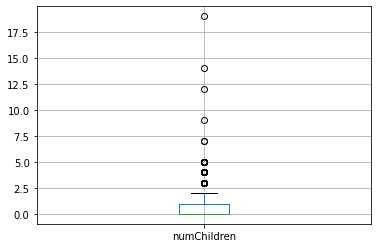

In [23]:
applications3.boxplot('numChildren')

<AxesSubplot:>

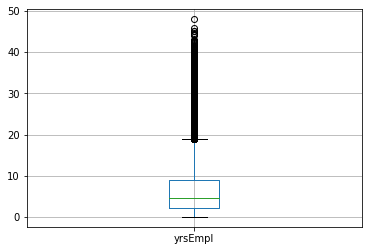

In [24]:
applications3.boxplot('yrsEmpl')

<AxesSubplot:>

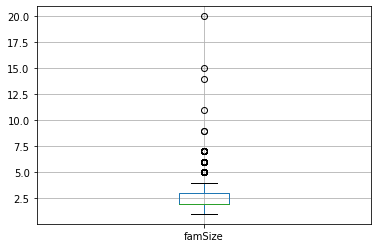

In [25]:
applications3.boxplot('famSize')

Text(0.5, 1.0, 'Distribution of Applicant Age')

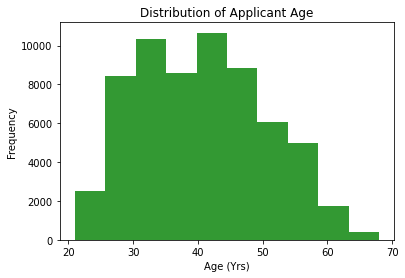

In [26]:
num_bins = 10
n, bins, patches = plt.hist(applications3['age'], num_bins, facecolor='green', alpha = .8)
plt.xlabel('Age (Yrs)')
plt.ylabel('Frequency')
plt.title('Distribution of Applicant Age')

<AxesSubplot:>

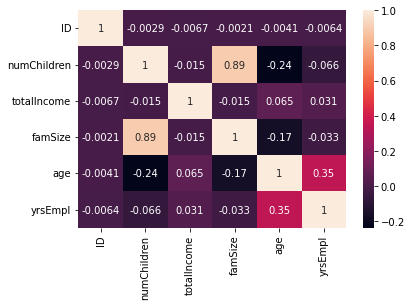

In [27]:
# Correlation matrix
sns.heatmap(applications3.corr(), annot=True)

#### Categorical Variable Distributions

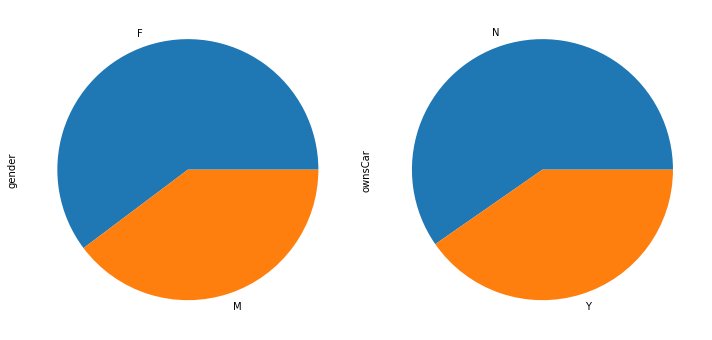

In [28]:
fig, axes = plt.subplots(1,2)
g1 = applications3.groupby('gender')['gender'].count().plot(kind='pie', y='gender', ax=axes[0])
g2 = applications3.groupby('ownsCar')['ownsCar'].count().plot(kind='pie', y='ownsCar', ax=axes[1])

fig.set_size_inches(10,5)

plt.tight_layout()

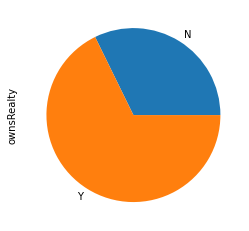

In [29]:
g3 = applications3.groupby('ownsRealty')['ownsRealty'].count().plot(kind='pie', y='ownsRealty')

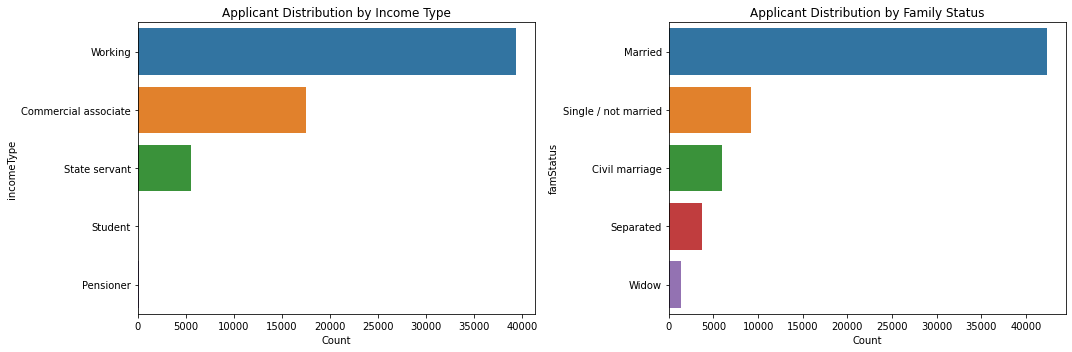

In [30]:
# Income type, family status distributions

fig, axes = plt.subplots(1,2)

incTDist=sns.countplot(y=applications3.incomeType,linewidth=1.2, ax=axes[0])
incTDist.set_title("Applicant Distribution by Income Type")
incTDist.set_xlabel("Count")

famDist=sns.countplot(y=applications3.famStatus,linewidth=1.2, ax=axes[1])
famDist.set_title("Applicant Distribution by Family Status")
famDist.set_xlabel("Count")

fig.set_size_inches(15,5)

plt.tight_layout()

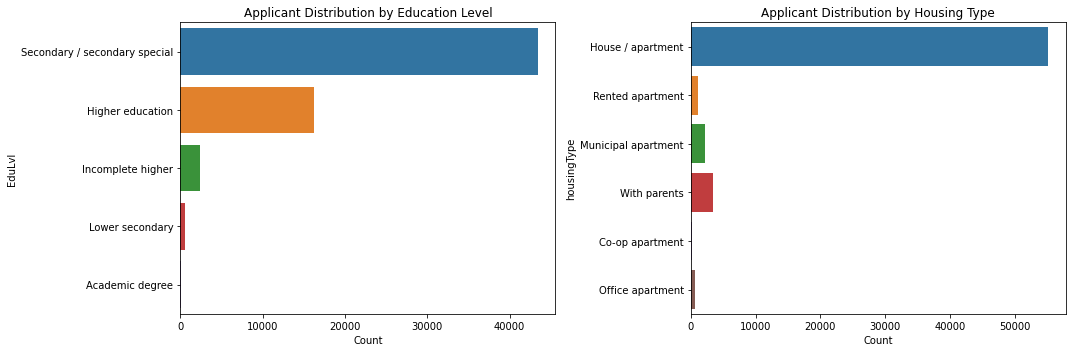

In [31]:
# education type, housing type

fig, axes = plt.subplots(1,2)

eduTDist=sns.countplot(y=applications3.EduLvl,linewidth=1.2, ax=axes[0])
eduTDist.set_title("Applicant Distribution by Education Level")
eduTDist.set_xlabel("Count")

houDist=sns.countplot(y=applications3.housingType,linewidth=1.2, ax=axes[1])
houDist.set_title("Applicant Distribution by Housing Type")
houDist.set_xlabel("Count")

fig.set_size_inches(15,5)

plt.tight_layout()

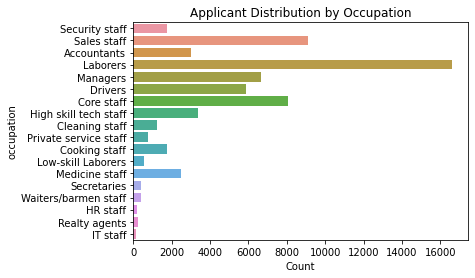

In [32]:
# dist by occupation
occuDist=sns.countplot(y=applications3.occupation,linewidth=1.2)
occuDist.set_title("Applicant Distribution by Occupation")
occuDist.set_xlabel("Count")

fig.set_size_inches(5,5)

plt.show()

In [35]:
# convert floats to integers

applications3.totalIncome = applications3.totalIncome.astype(int)


C:\Users\dez_g\AppData\Local\Temp\ipykernel_19336\997865412.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  applications3.totalIncome = applications3.totalIncome.astype(int)


In [36]:
applications3.age = applications3.age.astype(int)
applications3.famSize = applications3.famSize.astype(int)
applications3.yrsEmpl = applications3.yrsEmpl.astype(int)

C:\Users\dez_g\AppData\Local\Temp\ipykernel_19336\2651461775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  applications3.age = applications3.age.astype(int)
C:\Users\dez_g\AppData\Local\Temp\ipykernel_19336\2651461775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  applications3.famSize = applications3.famSize.astype(int)
C:\Users\dez_g\AppData\Local\Temp\ipykernel_19336\2651461775.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [37]:
applications3.head()

,ID,gender,ownsCar,ownsRealty,numChildren,totalIncome,incomeType,EduLvl,famStatus,housingType,occupation,famSize,age,yrsEmpl
2,5008806,M,Y,Y,0,112500,Working,Secondary / secondary special,Married,House / apartment,Security staff,2,59,3
3,5008808,F,N,Y,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,1,53,8
10,5008815,M,Y,Y,0,270000,Working,Higher education,Married,House / apartment,Accountants,2,47,2
13,5008819,M,Y,Y,0,135000,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,2,49,3
19,5008825,F,Y,N,0,130500,Working,Incomplete higher,Married,House / apartment,Accountants,2,30,3


In [34]:
applications3.gender.value_counts()

F    37711
M    24871
Name: gender, dtype: int64

In [35]:
applications3.ownsCar.value_counts()

N    37339
Y    25243
Name: ownsCar, dtype: int64

In [36]:
applications3.ownsRealty.value_counts()

Y    42395
N    20187
Name: ownsRealty, dtype: int64

In [38]:
# dummy code binary variables

def genderRecode (series):
    if series == "F":
        return 0
    if series == "M":
        return 1
applications3['genderR'] = applications3['gender'].apply(genderRecode)


C:\Users\dez_g\AppData\Local\Temp\ipykernel_19336\2880319282.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  applications3['genderR'] = applications3['gender'].apply(genderRecode)


In [39]:

def carRecode (series):
    if series == "N":
        return 0
    if series == "Y":
        return 1
applications3['ownsCarR'] = applications3['ownsCar'].apply(carRecode)


C:\Users\dez_g\AppData\Local\Temp\ipykernel_19336\534455497.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  applications3['ownsCarR'] = applications3['ownsCar'].apply(carRecode)


In [41]:

def realtyRecode (series):
    if series == "N":
        return 0
    if series == "Y":
        return 1
applications3['ownsRealtyR'] = applications3['ownsRealty'].apply(realtyRecode)


C:\Users\dez_g\AppData\Local\Temp\ipykernel_19336\3082916272.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  applications3['ownsRealtyR'] = applications3['ownsRealty'].apply(realtyRecode)


In [42]:
applications3.head()

,ID,gender,ownsCar,ownsRealty,numChildren,totalIncome,incomeType,EduLvl,famStatus,housingType,occupation,famSize,age,yrsEmpl,genderR,ownsCarR,ownsRealtyR
2,5008806,M,Y,Y,0,112500,Working,Secondary / secondary special,Married,House / apartment,Security staff,2,59,3,1,1,1
3,5008808,F,N,Y,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,1,53,8,0,0,1
10,5008815,M,Y,Y,0,270000,Working,Higher education,Married,House / apartment,Accountants,2,47,2,1,1,1
13,5008819,M,Y,Y,0,135000,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,2,49,3,1,1,1
19,5008825,F,Y,N,0,130500,Working,Incomplete higher,Married,House / apartment,Accountants,2,30,3,0,1,0


In [40]:
# merge the data sets (found that by merging, several data points were created for the same ID depending
# on months balance; use for predictions only, not vintage analysis
merged = pd.merge(applications3, records, on="ID")

In [41]:
merged.head()

,ID,gender,ownsCar,ownsRealty,numChildren,totalIncome,incomeType,EduLvl,famStatus,housingType,occupation,famSize,age,yrsEmpl,genderR,ownsCarR,ownsRealtyR,MONTHS_BALANCE,STATUS
0,5008806,M,Y,Y,0,112500,Working,Secondary / secondary special,Married,House / apartment,Security staff,2,59,3,1,1,1,0,C
1,5008806,M,Y,Y,0,112500,Working,Secondary / secondary special,Married,House / apartment,Security staff,2,59,3,1,1,1,-1,C
2,5008806,M,Y,Y,0,112500,Working,Secondary / secondary special,Married,House / apartment,Security staff,2,59,3,1,1,1,-2,C
3,5008806,M,Y,Y,0,112500,Working,Secondary / secondary special,Married,House / apartment,Security staff,2,59,3,1,1,1,-3,C
4,5008806,M,Y,Y,0,112500,Working,Secondary / secondary special,Married,House / apartment,Security staff,2,59,3,1,1,1,-4,C


In [ ]:
# drop duplicates
merged=merged.drop_duplicates(subset=merged.columns[1:], keep='first')

In [1]:
merged.head()

NameError: name 'merged' is not defined